<img src="./Data/公式.png" style="zoom:50%;" />

# Import

In [1]:
from sympy import*
import numpy as np
from pyDOE import lhs         #Latin Hypercube Sampling
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D   
import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp #TFP needs TF>= 2.3
import time

tf.random.set_seed(1234)
np.random.seed(1234)

# Setting

In [3]:

x = symbols('x')
y = symbols('y')
t = symbols('t')

a = v1 = v2 = k =1 #a=4 ,v1=5,v2=10,k=1/4
c1 = 1 + v1/k ;c2 = -v1/v2;c3 = c2 - c1
g1 = g2 =0

u1 = a*x*(1-x)*(1-y)*exp(-t)
u2 = a*x*(1-x)*(c1 + c2*y + c3*y**2)*exp(-t)

f1 = diff(u1,t) - v1*( diff(u1,x,2) + diff(u1,y,2))
f2 = diff(u2,t) - v2*( diff(u2,x,2) + diff(u2,y,2))

u1 = lambdify((x,y,t),u1)
u2 = lambdify((x,y,t),u2)

f1 = lambdify((x,y,t),f1,'tensorflow')
f2 = lambdify((x,y,t),f2,'tensorflow')

# TrainingData & TestData

In [4]:
def trainingdata(N_u,N_f,N_i,omga,regions,u,interface):    
    '''
      x1 = x,  x2 = y
      若interface = 0, 则x2_range[0] 作为 interface ；若interfacer = 1 则 x2_range[1]作为interface
      regions = [regions_x,regions_y] 
      i.e:  regions_x = [[0.1,0.3],[0.4,0.6]]
          regions_y = [[0.1,0.3],[0.4,0.6],[0.7,0.9]]
          Total nums of sub_regions = 2*3
      Return: X_u_train (N_u x 3),u_train (N_u x 1), X_f_train (N_f x 3), X_i_train (N_i x 3)
    '''
    x1_range = omga[0]
    x2_range = omga[1]
    t_range = [0.,1.]

    all_X_u_train = []
    all_u_train = []

    # Initial Condition t=0 , x1_range[0]<= x1 <= x_range[1] , x2_range[0] <= x2 <= x2_range[1]
    lb = np.array([x1_range[0],x2_range[0],t_range[0]])
    ub = np.array([x1_range[1],x2_range[1],t_range[0]])
    initial_X = lb + (ub-lb)*lhs(3,N_u)
    initial_u = u(initial_X[:,0], initial_X[:,1], initial_X[:,2]).reshape(-1,1)
    
    all_X_u_train.append(initial_X)
    all_u_train.append(initial_u)


    regions_x = regions[0]
    regions_y = regions[1]
    num_regions = len(regions_x)*len(regions_y)
    for x_range in regions_x:
      for y_range in regions_y:
        lb = np.array([x_range[0],y_range[0],t_range[0]])
        ub = np.array([x_range[1],y_range[1],t_range[1]])
        region_X = lb + (ub-lb)*lhs(3,int(N_u/num_regions))
        region_u = u(region_X[:,0],region_X[:,1],region_X[:,2]).reshape(-1,1)

        all_X_u_train.append(region_X)
        all_u_train.append(region_u)  
    
    all_X_u_train =  np.vstack(all_X_u_train)
    all_u_train = np.vstack(all_u_train)
    
    idx = np.random.choice(all_X_u_train.shape[0],all_X_u_train.shape[0], replace=False) 
    
    X_u_train = all_X_u_train[idx,:]
    u_train = all_u_train[idx,:]
    
    # BC_interface: x2 = x2_range[interface], 0<=t<=1 ,x1_range[0]<= x1 <= x_range[1]
    lb = np.array([x1_range[0],x2_range[interface],t_range[0]])
    ub = np.array([x1_range[1],x2_range[interface],t_range[1]])
    X_i_train = lb + (ub-lb)*lhs(3,N_i)    
            
    '''Collocation Points'''
    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x1,x2,t)
    lb = np.array([x1_range[0],x2_range[0],t_range[0]])
    ub = np.array([x1_range[1],x2_range[1],t_range[1]])
    X_f_train = lb + (ub-lb)*lhs(3,N_f) 
    X_f_train = np.vstack((X_f_train, X_u_train)) # append training points to collocation points 
    
    return X_u_train,u_train,X_f_train,X_i_train

def ds_train_n_batch(X_u1_train,u1_train,X_f1_train,X_u2_train,u2_train,X_f2_train,X_i_train,n = 5):
    batch_u1 = int(len(X_u1_train)/n) # = int(len(u1_train)/n)
    batch_f1 = int(len(X_f1_train)/n)

    batch_u2 = int(len(X_u2_train)/n) # = int(len(u2_train)/n)
    batch_f2 = int(len(X_f2_train)/n)
    
    batch_i = int(len(X_i_train)/n)
    
    ds_u1 = tf.data.Dataset.from_tensor_slices( ((X_u1_train,u1_train)) ).batch( batch_u1 )
    ds_f1 = tf.data.Dataset.from_tensor_slices( X_f1_train ).batch( batch_f1 )
    
    ds_u2 = tf.data.Dataset.from_tensor_slices( ((X_u2_train,u2_train)) ).batch( batch_u2 )
    ds_f2 = tf.data.Dataset.from_tensor_slices( X_f2_train ).batch( batch_f2 )
    
    ds_i = tf.data.Dataset.from_tensor_slices(X_i_train).batch(batch_i)

    ds = tf.data.Dataset.zip((ds_u1,ds_f1,ds_u2,ds_f2,ds_i))
    return ds

In [5]:
omga1 = [[0.,1.],[0.,1.]]  # (x,y)的取值范围 
omga2 = [[0.,1.],[-1.,0.]] 
def test_data(N,omga,u,t=1.0):
  # Output: X,Y,T,U shape=(N,N)
  x_range = tf.linspace(omga[0][0],omga[0][1],N)
  y_range = tf.linspace(omga[1][0],omga[1][1],N)

  X,Y = tf.meshgrid(x_range,y_range)
  T = tf.ones(shape=X.shape)*t
  U = u(X,Y,T)
  return X,Y,T,U

def pred_data(X,Y,T,model):
  #Input: X,Y,T shape=(N,N)
  #Output: U_pred shape=(N,N)
  Shape = X.shape
  dim = len(Shape)
  X = tf.reshape(X,shape=(Shape[0]**dim,1))
  Y = tf.reshape(Y,shape=(Shape[0]**dim,1))
  T = tf.reshape(T,shape=(Shape[0]**dim,1))

  Inputs = tf.concat([X,Y,T],axis=1)
  U_pred = model(Inputs)
  U_pred = tf.reshape(U_pred,shape=Shape)
  return U_pred


# PINN Model

## Single PINN

In [6]:
class MyPinn(keras.Sequential): 
    def __init__(self,Layers,v,n,k,f,name = None): #Layers=[3,20,20,1]
        super(MyPinn, self).__init__(name=name)
        self.add(keras.Input(shape=(Layers[0],) ,dtype=tf.float64))
        for i in range(1,len(Layers)-1):
            self.add(keras.layers.Dense(Layers[i], dtype=tf.float64, activation='tanh'))
        self.add(keras.layers.Dense(Layers[-1],dtype=tf.float64, name="outputs"))
        self.v0 = tf.constant(v,dtype=tf.float64)
        self.v = tf.Variable(0.0,dtype=tf.float64)
        self.n = tf.constant(n,dtype=tf.float64)
        self.k = tf.constant(k,dtype=tf.float64)
        self.f = f
        
    @tf.function
    def loss_U(self,X_u_train,u_train):
        u= self(X_u_train)
        loss_u = tf.reduce_mean(tf.square(u_train - u))
        return loss_u
    #   
    @tf.function
    def loss_PDE(self,X_f_train):
        x = X_f_train[:,0:1]
        y = X_f_train[:,1:2]
        t = X_f_train[:,2:3]
        with tf.GradientTape(persistent=True) as tape:
            tape.watch([x,y,t])
            X = tf.stack([x[:,0],y[:,0],t[:,0]],axis=1)
            u = self(X)  
            u_x = tape.gradient(u,x)
            u_y = tape.gradient(u,y)
            #u_t = tape.gradient(u,t)
        #tf.print(u_x)    
        u_t = tape.gradient(u, t)     
        u_xx = tape.gradient(u_x, x)
        u_yy = tape.gradient(u_y, y)

        del tape
      
        loss_f = u_t - self.v *(u_xx + u_yy) - self.f(x,y,t)
        loss_f = tf.reduce_mean(tf.square(loss_f))
        return loss_f
    """以下为单区域PINN 训练方法"""    
    @tf.function
    def train_loop(self,X_u_train,u_train,X_f_train):
      with tf.GradientTape() as tape:
        loss = self.loss_U(X_u_train,u_train) + self.loss_PDE(X_f_train)
      gradients = tape.gradient(loss,self.trainable_variables)
      self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

      return loss

    def train(self,X_u_train,u_train,X_f_train,epochs=200):
      for epoch in tf.range(1,epochs+1):
          loss = self.train_loop(X_u_train,u_train,X_f_train)
          if epoch % 50 == 0:                
              tf.print(
                  "Training loss (for per 10 epoches) at epoch ",epoch,":",loss
              )

## Couple PINN

In [7]:
class CouplePinn(keras.Model):
  def __init__(self,model_1,model_2,name=None):
    super(CouplePinn,self).__init__(name=name)
    self.m1 = model_1 
    self.m2 = model_2
    
    # Metrics
    self.loss_tracker = keras.metrics.Mean(name="loss")
    self.v1_tracker = keras.metrics.Mean(name="m1.v")
    self.v2_tracker = keras.metrics.Mean(name="m2.v")
    self.loss_u1 = keras.metrics.Mean(name="loss_u1")
    self.loss_u2 = keras.metrics.Mean(name="loss_u2")
    self.loss_i = keras.metrics.Mean(name="loss_i")

    # Self-Adaptive factors     
    self.alpha1 = tf.Variable(0.0, dtype = tf.float64, trainable = True)     
    self.alpha2 = tf.Variable(0.0, dtype = tf.float64, trainable = True)

    self.optimizer_alpha = keras.optimizers.Adam(learning_rate=0.05)
  @property
  def metrics(self):
      # We list our `Metric` objects here so that `reset_states()` can be
      # called automatically at the start of each epoch
      # or at the start of `evaluate()`.
      # If you don't implement this property, you have to call
      # `reset_states()` yourself at the time of your choosing.
      m = [self.loss_tracker,self.loss_u1,self.loss_u2,self.loss_i,self.v1_tracker,self.v2_tracker] 
      return m 


  """ 交界处损失函数 """
  @tf.function
  def loss_I(self,X_i_train):
      x = X_i_train[:,0:1]
      y = X_i_train[:,1:2]
      t = X_i_train[:,2:3]
      
      with tf.GradientTape(persistent=True) as tape:
          tape.watch([x,y,t])
          X = tf.stack([x[:,0],y[:,0],t[:,0]],axis=1)
          U1 = self.m1(X)
          U2 = self.m2(X)
      
      U1_x = tape.gradient(U1, x)
      U1_y = tape.gradient(U1, y)
      U2_x = tape.gradient(U2, x)
      U2_y = tape.gradient(U2, y)

      del tape
      
      loss_i1 = -self.m1.v * ( U1_x*self.m1.n[0] + U1_y*self.m1.n[1]) - self.m1.k * (U1-U2)
      loss_i2 = -self.m2.v * ( U2_x*self.m2.n[0] + U2_y*self.m2.n[1]) - self.m2.k * (U2-U1)

      loss_i1 = tf.reduce_mean(tf.square(loss_i1)) 
      loss_i2 = tf.reduce_mean(tf.square(loss_i2))

      return loss_i1,loss_i2
  @tf.function
  def loss_Total(self,X_u_train,u_train,X_f_train,X_i_train):
    (X_u1_train,X_u2_train) = X_u_train
    (u1_train,u2_train) = u_train
    (X_f1_train,X_f2_train) = X_f_train
    
    loss_m1 = self.m1.loss_U(X_u1_train,u1_train) + self.m1.loss_PDE(X_f1_train)
    loss_m2 = self.m2.loss_U(X_u2_train,u2_train) + self.m2.loss_PDE(X_f2_train)
    loss_i1,loss_i2 = self.loss_I(X_i_train)
    return (loss_m1+loss_i1) + (loss_m2+loss_i2)

  """耦合区域 PINN训练方法"""
  @tf.function
  def train_step(self,data):
      (X_u1_train,u1_train),X_f1_train,(X_u2_train,u2_train),X_f2_train,X_i_train = data #unpack
      with tf.GradientTape(persistent=True) as tape: 
          loss_m1 = self.m1.loss_U(X_u1_train,u1_train) + self.m1.loss_PDE(X_f1_train)
          loss_m2 = self.m2.loss_U(X_u2_train,u2_train) + self.m2.loss_PDE(X_f2_train)
          loss_i1,loss_i2 = self.loss_I(X_i_train)

          a1 = tf.math.sigmoid(5*self.alpha1) * 2.0
          a2 = tf.math.sigmoid(5*self.alpha2) * 2.0
          loss_adaptive = a1*(loss_m1+loss_i1) + a2*(loss_m2+loss_i2)

      loss = loss_m1 + loss_m2 + loss_i1 + loss_i2
      # Compute gradients
      gradients_m1 = tape.gradient(loss_adaptive,self.m1.trainable_variables)
      gradients_m2 = tape.gradient(loss_adaptive,self.m2.trainable_variables)
      gradient_a1pha1 = -tape.gradient(loss_adaptive,self.alpha1)
      gradient_alpha2 = -tape.gradient(loss_adaptive,self.alpha2)

      del tape

      # Updata parameters
      self.m1.optimizer.apply_gradients(zip(gradients_m1, self.m1.trainable_variables))
      self.m2.optimizer.apply_gradients(zip(gradients_m2, self.m2.trainable_variables))
      self.optimizer_alpha.apply_gradients( zip([gradient_a1pha1,gradient_alpha2], [self.alpha1,self.alpha2]) )

      # Updata Metric
      #self.loss_adaptive.update_state(loss_adaptive)
      self.v1_tracker.update_state(self.m1.v)
      self.v2_tracker.update_state(self.m2.v)
      self.loss_tracker.update_state(loss)
      self.loss_u1.update_state(loss_m1+loss_i1)
      self.loss_u2.update_state(loss_m2+loss_i2)
      self.loss_i.update_state(loss_i1+loss_i2)

      metrics = {m.name : m.result() for m in self.metrics}

      return metrics
  

## function factory

In [8]:
def function_factory(model,loss,X_u_train,u_train,X_f_train,X_i_train):
    """A factory to create a function required by tfp.optimizer.lbfgs_minimize.
    Args:
        model [in]: an instance of `tf.keras.Model` or its subclasses.
        loss [in]: a loss function in model
    Returns:
        A function that has a signature of:
            loss_value, gradients = f(model_parameters).
    """

    # obtain the shapes of all trainable parameters in the model
    shapes = [tf.shape_n(model.m1.trainable_variables),tf.shape_n(model.m2.trainable_variables)]
    n_tensors = [len(shapes[0]),len(shapes[1])]

    # we'll use tf.dynamic_stitch and tf.dynamic_partition later, so we need to
    # prepare required information first
    count = [0,0]
    idx = [[],[]] # stitch indices
    part = [[],[]] # partition indices

    for i,shapes_i in enumerate(shapes):
      for j, shape in enumerate(shapes_i):
          n = np.product(shape)
          idx[i].append(tf.reshape(tf.range(count[i], count[i]+n, dtype=tf.int32), shape))
          part[i].extend([j]*n)
          count[i] += n

    part = [ tf.constant(part[0]), tf.constant(part[1]) ]

    @tf.function
    def assign_new_model_parameters(params_1d):
        """A function updating the model's parameters with a 1D tf.Tensor.
        Args:
            params_1d [in]: a 1D tf.Tensor representing the model's trainable parameters.
        """
        count0 = count[0]
        count1 = count[1]

        params0 = tf.dynamic_partition(params_1d[0:count0], part[0], n_tensors[0])
        for i, (shape, param) in enumerate(zip(shapes[0], params0)):
            model.m1.trainable_variables[i].assign(tf.reshape(param, shape))
        
        params1 = tf.dynamic_partition(params_1d[count0:count0+count1], part[1], n_tensors[1])
        for i, (shape, param) in enumerate(zip(shapes[1], params1)):
            model.m2.trainable_variables[i].assign(tf.reshape(param, shape))
        '''
        num = 0
        for k in tf.range(0,2):
          params = tf.dynamic_partition(params_1d[num:num+count[k]], part[k], n_tensors[k])
          for i, (shape, param) in enumerate(zip(shapes, params)):
            model.m[k].trainable_variables[i].assign(tf.reshape(param, shape))
          num += count[k]
        '''
    # now create a function that will be returned by this factory
    @tf.function
    def f(params_1d):
        """A function that can be used by tfp.optimizer.lbfgs_minimize.
        This function is created by function_factory.
        Args:
           params_1d [in]: a 1D tf.Tensor.
        Returns:
            A scalar loss and the gradients w.r.t. the `params_1d`.
        """

        # use GradientTape so that we can calculate the gradient of loss w.r.t. parameters
        with tf.GradientTape(persistent=True) as tape:
            # update the parameters in the model
            assign_new_model_parameters(params_1d)
            # calculate the loss
            loss_total = loss(X_u_train,u_train,X_f_train,X_i_train)

        # calculate gradients and convert to 1D tf.Tensor
        grads_m1 = tape.gradient(loss_total, model.m1.trainable_variables)
        grads_m2 = tape.gradient(loss_total, model.m2.trainable_variables)

        grads_m1 = tf.dynamic_stitch(idx[0], grads_m1)
        grads_m2 = tf.dynamic_stitch(idx[1], grads_m2)

        grads = tf.concat([grads_m1,grads_m2],axis=0)
        
        del tape

        # print out iteration & loss
        f.iter.assign_add(1)
        if (f.iter % 50 == 0) :
          tf.print("Iter:", f.iter, "loss:", loss_total)

        # store loss value so we can retrieve later
        tf.py_function(f.history.append, inp=[loss_total], Tout=[])

        return loss_total, grads

    # store these information as members so we can use them outside the scope
    f.iter = tf.Variable(0)
    f.idx = idx
    f.part = part
    f.shapes = shapes
    f.assign_new_model_parameters = assign_new_model_parameters
    f.history = []
    f.count = count
    return f

# Train

In [9]:
""" Training Data """
n1 = [0.,-1.]
n2 = [0.,1.]

omga1 = [[0.,1.],[0.,1.]]  # (x,y)的取值范围 
omga2 = [[0.,1.],[-1.,0.]] 

N_i = 200
"""X_f_train包含X_u_train,参数反问题知道数值真解，自然带标签的训练集要多一些"""

N_u1 = 2000; N_f1 = 200  ;omga = omga1; interface=0; u = u1
regions_x = [ omga1[0]  ]
regions_y = [ omga1[1]  ]
regions = [regions_x,regions_y]
X_u1_train,u1_train,X_f1_train,X_i_train= trainingdata(N_u1,N_f1,N_i,omga,regions,u,interface)


N_u2 = 2000; N_f2= 200 ; omga = omga2; interface=1; u = u2
regions_x = [ omga2[0] ]
regions_y = [ omga2[1] ]
regions = [regions_x,regions_y]
X_u2_train,u2_train,X_f2_train,X_i_train= trainingdata(N_u2,N_f2,N_i,omga,regions,u,interface)

""" Test Data """
N = 100
X_u1,Y_u1,T_u1,U1 = test_data(N,omga1,u1,t=1.0)
X_u2,Y_u2,T_u2,U2 = test_data(N,omga2,u2,t=1.0)

In [10]:
Layers=[3,20,20,20,20,1]
model_u1 = MyPinn(Layers,v1,n1,k,f1,name="model_1")
model_u1.compile(optimizer=keras.optimizers.Adam())

model_u2 = MyPinn(Layers,v2,n2,k,f2,name="model_2")
model_u2.compile(optimizer=keras.optimizers.Adam())

ds = ds_train_n_batch(X_u1_train, u1_train , X_f1_train , X_u2_train , u2_train , X_f2_train , X_i_train ,n = 10)

In [3]:
class CustomMSE(keras.losses.Loss):
    def __init__(self, regularization_factor=0.1, name="custom_mse"):
        super().__init__(name=name)
        self.regularization_factor = regularization_factor

    def call(self, y_true, y_pred):
        mse = tf.math.reduce_mean(tf.square(y_true - y_pred))
        reg = tf.math.reduce_mean(tf.square(0.5 - y_pred))
        return mse,reg

In [4]:
inputs = keras.Input(shape=(5,))

x = tf.keras.layers.Dense(
    5,
    kernel_initializer='ones',
    kernel_regularizer=tf.keras.regularizers.L1(0.01),
    activity_regularizer=tf.keras.regularizers.L2(0.01)
)(inputs)

outputs = keras.layers.Dense(1,kernel_initializer='ones')(x)
m = keras.Model(inputs,outputs)
tensor = tf.ones(shape=(1, 5))

m.compile(loss=CustomMSE(),
        metrics=["mse"] )

m.evaluate(tensor,tensor)

1/1 [==============================] - 2s 2s/step - loss: 589.6250 - mse: 576.0000


[589.625, 576.0]

In [10]:
l1 = tf.keras.regularizers.L1(0.01)
x = tf.Variable(1.0)
y = tf.Variable(1.0)

l1([x,y])

<tf.Tensor: shape=(), dtype=float32, numpy=0.02>

In [6]:
m.layers[-1].activation

<function keras.activations.linear(x)>

In [51]:
m.loss(tensor,tensor)

<tf.Tensor: shape=(), dtype=float32, numpy=0.125>

In [ ]:
model_u1.train(X_u1_train,u1_train,X_f1_train,epochs=200) #单区域PINN训练
model_u2.train(X_u2_train,u2_train,X_f2_train,epochs=200) #单区域PINN训练

Training loss (for per 10 epoches) at epoch  50 : 0.18861580668489075
Training loss (for per 10 epoches) at epoch  100 : 0.073373630242557913
Training loss (for per 10 epoches) at epoch  150 : 0.063900540280261209
Training loss (for per 10 epoches) at epoch  200 : 0.058783820943449569
Training loss (for per 10 epoches) at epoch  50 : 1.735492880602995
Training loss (for per 10 epoches) at epoch  100 : 1.1794328688055991
Training loss (for per 10 epoches) at epoch  150 : 0.95596374789152327
Training loss (for per 10 epoches) at epoch  200 : 0.82890694653550745


In [ ]:
couple_model = CouplePinn(model_u1,model_u2) 
couple_model.compile()

In [ ]:
couple_model.fit(ds,epochs=500) #耦合PINN训练 Adam

10/10 [==============================] - 0s 40ms/step - loss: 0.0072 - loss_u1: 0.0021 - loss_u2: 0.0051 - loss_i: 4.7463e-04 - m1.v: 0.6718 - m2.v: 0.8707
Epoch 212/500
10/10 [==============================] - 0s 37ms/step - loss: 0.0072 - loss_u1: 0.0021 - loss_u2: 0.0050 - loss_i: 4.7583e-04 - m1.v: 0.6727 - m2.v: 0.8716
Epoch 213/500
10/10 [==============================] - 0s 39ms/step - loss: 0.0071 - loss_u1: 0.0021 - loss_u2: 0.0050 - loss_i: 4.7707e-04 - m1.v: 0.6737 - m2.v: 0.8725
Epoch 214/500
10/10 [==============================] - 0s 40ms/step - loss: 0.0071 - loss_u1: 0.0021 - loss_u2: 0.0050 - loss_i: 4.7834e-04 - m1.v: 0.6746 - m2.v: 0.8734
Epoch 215/500
10/10 [==============================] - 0s 33ms/step - loss: 0.0071 - loss_u1: 0.0021 - loss_u2: 0.0050 - loss_i: 4.7964e-04 - m1.v: 0.6755 - m2.v: 0.8742
Epoch 216/500
10/10 [==============================] - 0s 37ms/step - loss: 0.0070 - loss_u1: 0.0021 - loss_u2: 0.0049 - loss_i: 4.8096e-04 - m1.v: 0.6763 - m2.v: 0

In [ ]:
func = function_factory(couple_model, couple_model.loss_Total,
              (X_u1_train,X_u2_train), (u1_train,u2_train), (X_f1_train,X_f2_train), X_i_train )
params_1d_m1 = tf.dynamic_stitch(func.idx[0], couple_model.m1.trainable_variables)
params_1d_m2 = tf.dynamic_stitch(func.idx[1], couple_model.m2.trainable_variables)
params_1d = tf.concat([params_1d_m1,params_1d_m2],axis=0)
## L-BFGS 优化阶段
results = tfp.optimizer.lbfgs_minimize(
    value_and_gradients_function=func,
    initial_position=params_1d, 
    num_correction_pairs=20, 
    x_tolerance = 0,
    f_relative_tolerance = 0,
    tolerance = 1*np.finfo(float).eps,
    parallel_iterations = 1,
    max_line_search_iterations = 100,
    max_iterations=2000)


Iter: 50 loss: 0.002160879007309264
Iter: 100 loss: 0.0020307981720894788
Iter: 150 loss: 0.0019456652813335154
Iter: 200 loss: 0.0018609793286987076
Iter: 250 loss: 0.0017597422345507539
Iter: 300 loss: 0.001689541154708051
Iter: 350 loss: 0.0016346725341092551
Iter: 400 loss: 0.0015826743464625495
Iter: 450 loss: 0.0014934319919968164
Iter: 500 loss: 0.0013745091389084773
Iter: 550 loss: 0.001315467597408738
Iter: 600 loss: 0.0012373664230272093
Iter: 650 loss: 0.0011825600221930265
Iter: 700 loss: 0.0011292180528193435
Iter: 750 loss: 0.0010735959900395574
Iter: 800 loss: 0.0010294301541112758
Iter: 850 loss: 0.00096627388713279043
Iter: 900 loss: 0.00091489142550310446
Iter: 950 loss: 0.00087211733494293
Iter: 1000 loss: 0.00081649916394357154
Iter: 1050 loss: 0.00077618849559905911
Iter: 1100 loss: 0.00072595432019873667
Iter: 1150 loss: 0.00069169524167263718
Iter: 1200 loss: 0.00065338861973282514
Iter: 1250 loss: 0.00059524121235821027
Iter: 1300 loss: 0.0005576777307409052
Ite

# Plot

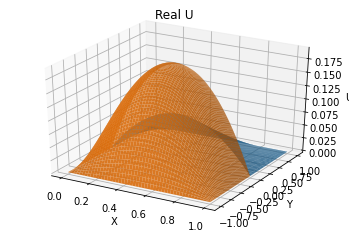

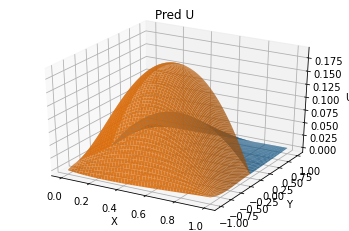

In [ ]:
U1_pred = pred_data(X_u1,Y_u1,T_u1,model_u1)
U2_pred = pred_data(X_u2,Y_u2,T_u2,model_u2)
####################################################
plt.figure(1) 
ax1 = plt.axes(projection="3d")
ax1.patch.set_facecolor("white")   #设置 axes 背景颜色

ax1.plot_surface(X_u1,Y_u1,U1,alpha=0.9) #生成曲面z，alpha调节透明度，cmap调节曲面色调
ax1.plot_surface(X_u2,Y_u2,U2,alpha=0.9)

ax1.set_xlabel("X")   
ax1.set_ylabel("Y")
ax1.set_zlabel("U")
ax1.set_title("Real U")
######################################################
plt.figure(2) 
ax2 = plt.axes(projection="3d")
ax2.patch.set_facecolor("white") 

### u1
ax2.plot_surface(X_u1,Y_u1,U1_pred,alpha=0.9)

###u2
ax2.plot_surface(X_u2,Y_u2,U2_pred,alpha=0.9)

ax2.set_xlabel("X")   
ax2.set_ylabel("Y")
ax2.set_zlabel("U")
ax2.set_title("Pred U")
###############################
plt.show()

In [ ]:
u1_real = U1.numpy().flatten()
u1_pred = U1_pred.numpy().flatten()
u2_real = U2.numpy().flatten()
u2_pred = U2_pred.numpy().flatten()

error_u1 = np.linalg.norm((u1_real-u1_pred),2)/np.linalg.norm(u1_real,2)  
print('Test Error For u1:  %.5f'  % (error_u1))

error_u2 = np.linalg.norm((u2_real-u2_pred),2)/np.linalg.norm(u2_real,2)  
print('Test Error For u2:  %.5f'  % (error_u2))

Test Error For u1:  0.01784
Test Error For u2:  0.01753


In [ ]:
tf.print( (model_u1.v,model_u2.v) )

(0.99404157288981077, 1.0019246376433226)


In [ ]:
tf.print("v=%f,real v=%f,error=%f " %(model_u1.v,model_u1.v0,tf.math.abs( (model_u1.v - model_u1.v0)/model_u1.v0) )  )

v=0.994042,real v=1.000000,error=0.005958 
